# Salinity from CORA dataset

The data can be obtained from Coriolis FTP at ftp://ftp1.ifremer.fr/Core/INSITU_GLO_TS_REP_OBSERVATIONS_013_001_b.
As an illustration, we will work with the OA data of December 2013. With this dataset, the profiles are vertically interpolated on specific depth levels.

Let's assume the datafile is as follows:

In [38]:
datafile = (
    '~/CMEMS_INSTAC/INSITU_GLO_TS_OA_REP_OBSERVATIONS_013_002_b/'
    'CORIOLIS-GLOBAL-CORA04.1-OBS_FULL_TIME_SERIE/data/2013/OA_CORA4.1_20131215_dat_PSAL.nc'
)

## Python modules

We import modules to read the netCDF file and to perform basic operations on the data.

In [36]:
import cf
from netCDF4 import Dataset
import numpy as np
import os

## Read data

As most of the file content is compliant with the [CF conventions](http://cfconventions.org/), we can use the [cf package](http://cfpython.bitbucket.org/) to read the variable we need:
* Longitude and latitude
* Time
* Depth
* Salinity

### Variable and coordinates

In [39]:
datafile = os.path.expanduser(datafile)

In [40]:
f = cf.read(datafile)
salinity = f.select('sea_water_salinity')[0].array
ftime = f.select('time')[0].array
lon = f.select('lon')[0].array
lat = f.select('lat')[0].array
depth = f.select('depth')[0].array
f.close()

We are just missing the variable that stores the quality flags. We will use the [netCDF4](unidata.github.io/netcdf4-python/) module.

In [41]:
with Dataset(datafile) as nc:
    salinityQC = nc.variables['PSAL_QC'][:]

The salinity data are organised in profiles, each of them with a time, a longitude and a latitude. We can exmaine the dimension of the coordinates:

In [42]:
print str(len(lon)) + ' available profiles'
print 'on ' + str(len(depth)) + ' depth levels.'

26693 available profiles
on 152 depth levels.


### Select one depth level

We can take the data on a given depth level to perform basic operations and a plot. Let's try with a depth of 100 meters.

In [43]:
mydepth = 100.

We compute the index of the level corresponding to that depth.

In [44]:
depthindex = np.argmin(abs(depth - mydepth))
print 'depthindex = ' + str(depthindex)

depthindex = 21


Now we take the salinity and its corresponding flags at that level.

In [45]:
salinity_atdepth = salinity[:, depthindex]
salinity_atdepth_QC = salinityQC[:, depthindex]

Let's examine the shape of the variables:

In [46]:
salinity_atdepth.shape

(26693,)

This would mean that we have 26693 measurements available at that depth. However, some values can be masked, because the profile doesn't reach that depth. So to compute the real number of observations, we can use *count* which is an in-place method of *cf*.

In [15]:
goodmeasurements = salinity_atdepth.count()
print str(goodmeasurements)  + ' data points available'

22361 data points available


### Quality flags

A quality flag (QF) is attributed to each measurement. We can easily count the measurements for each QF, using a loop from 0 to 9.

In [16]:
for qf in np.arange(0, 10):
        print 'QF=%s: %s profiles' % (qf, np.sum(salinity_atdepth_QC == qf))

QF=0: 0 profiles
QF=1: 21845 profiles
QF=2: 166 profiles
QF=3: 117 profiles
QF=4: 220 profiles
QF=5: 13 profiles
QF=6: 0 profiles
QF=7: 0 profiles
QF=8: 0 profiles
QF=9: 4332 profiles


* Most of the measurements have a QF=1 (**good**). 
* All the profiles have had a quality control applied (0 profiles with QF=0). 
* 4332 values have a QF=9 (**not_used**). They correspond to the profiles that don't reach the considered depth (*count* returns the number of non-masked elements of an array):

In [17]:
salinity_atdepth.shape[0] - salinity_atdepth.count()

4332

## Operations on data

### Extreme values

We can check what the minimal and maximal salinity values are, and their positions. Later we will represent them on a plot.

In [18]:
minsalinity, maxsalinity = np.min(salinity_atdepth), np.max(salinity_atdepth)
minsalinityindex, maxsalinityindex = np.argmin(salinity_atdepth), np.argmax(salinity_atdepth)
lonmin, latmin = lon[minsalinityindex], lat[minsalinityindex]
lonmax, latmax = lon[maxsalinityindex], lat[maxsalinityindex]

print 'Minimum salinity = %s at %sE, %sN' % (minsalinity, lonmin, latmin)
print 'Maximum salinity = %s at %sE, %sN' % (maxsalinity, lonmax, latmax)

Minimum salinity = 31.7042 at -63.5289473684E, 44.2437894737N
Maximum salinity = 40.1509 at 39.8E, 17.249N


### Basic statistics

In [19]:
meansalinity = salinity_atdepth.mean()
stdsalinity = salinity_atdepth.std()
print 'Mean salinity = ' + str(meansalinity)
print 'Standard deviation = ' + str(stdsalinity)

Mean salinity = 35.1335416573
Standard deviation = 1.068765854


## Plotting

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors

We will only consider the observations with QF=1. To do this, we could try selecting only the values of the array that satisfy the condition: 

In [21]:
salinity_plot = salinity_atdepth[salinity_atdepth_QC == 1]
print salinity_plot.shape
print lon.shape

(21845,)
(26693,)


but then the problem is that the new array has a different size from the size of the coordinates. This is why we prefer to mask the bad values (QF not equal to 1).

In [22]:
salinity_atdepth_masked = np.ma.masked_where(salinity_atdepth_QC != 1, salinity_atdepth)
lon_masked = np.ma.masked_where(salinity_atdepth_QC != 1, lon)
lat_masked = np.ma.masked_where(salinity_atdepth_QC != 1, lat)

We set the fontsize to 20 pts.

In [23]:
mpl.rcParams.update({'font.size': 20})

### Histogram

We start with a simple histogram showing the distribution, using 0.2 unit bins.

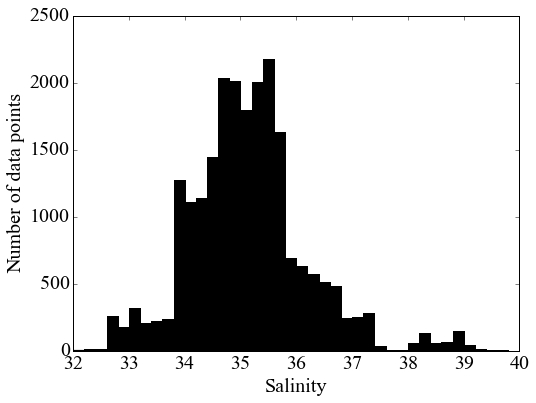

In [24]:
fig = plt.figure(figsize=(8,6))
plt.hist(salinity_atdepth_masked, np.arange(32., 40., 0.2))
plt.xlabel('Salinity')
plt.ylabel('Number of data points')
plt.show()

### Colored histogram

We start by defining the colormap and the limits for the histogram.

In [25]:
cmap = plt.cm.get_cmap('RdYlBu_r')
Y, X = np.histogram(salinity_atdepth_masked, np.arange(32., 40., 0.2))

Then we make the plot.

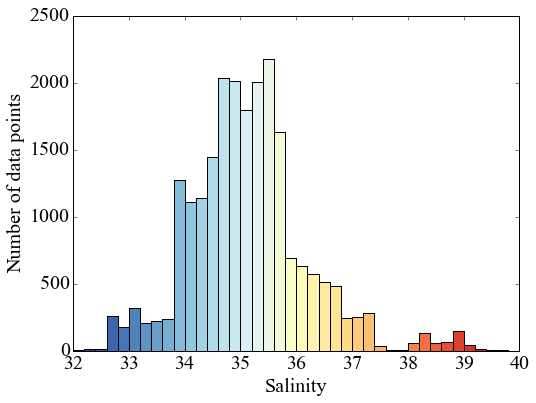

In [26]:
x_span = X.max() - X.min()
C = [cmap(((x - X.min()) / x_span)) for x in X]
fig = plt.figure(figsize=(8, 6))
plt.bar(X[:-1], Y, color=C, width=X[1]-X[0])
plt.xlabel('Salinity')
plt.ylabel('Number of data points')
plt.show()

### Scatter plot

We keep the same colormap as for the histogram and we define the range of values for the scatter plot.

In [27]:
norm = colors.Normalize(vmin=32., vmax=39.)

We create a scatter plot with colors scaled 32 and 39 and indicate the positions of the minimum and maximum salinity (squares).

/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


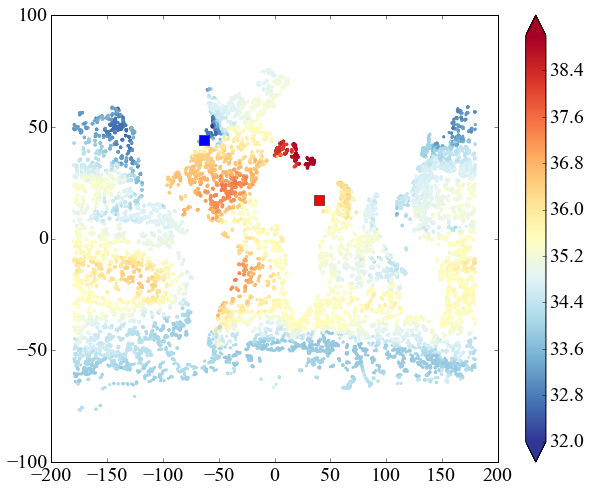

In [28]:
fig = plt.figure(figsize=(10,8))
scat = plt.scatter(lon, lat, s=10, c=salinity_atdepth_masked, edgecolor='None', cmap=cmap, norm=norm)
plt.plot(lonmax, latmax, 'rs', ms=10)
plt.plot(lonmin, latmin, 'bs', ms=10)
plt.colorbar(scat, extend='both')
plt.show()

We can do better by including coastline, scale and other labels.

### Scatter on a map

We first need to import the Basemap module to plot data on a map, then the projection has to be defined. We select a [*Mollweide* projection](http://matplotlib.org/basemap/users/moll.html) centered at 0º longitude, with a *crude* resolution for the coastline.

In [29]:
from mpl_toolkits.basemap import Basemap
m = Basemap(projection='moll', lon_0=0, resolution='c')

Before making the plot, it is necessary to transform the (lon, lat) coordinates into the new projection that we defined. 

In [30]:
lon_p, lat_p = m(lon_masked, lat_masked)

The plot is created with the same command as before, except that we use **m.scatter()** instead of **plt.scatter()**. 

In addition we will:
* add a coastline,
* shade the continent.

Finally, the colorbar will be placed below the map.

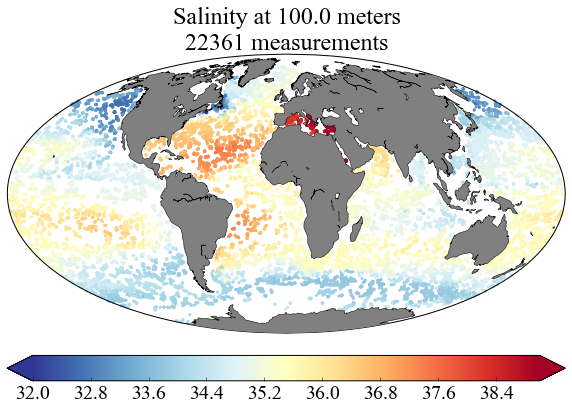

In [31]:
fig = plt.figure(figsize=(10,8))
m.scatter(lon_p, lat_p, s=10, c=salinity_atdepth_masked, edgecolor='None', cmap=cmap, norm=norm)
plt.colorbar(scat, extend='both', orientation='horizontal', pad=0.05)
m.fillcontinents(color='gray', lake_color='white')
m.drawcoastlines(linewidth=0.5)
plt.title('Salinity at ' + str(mydepth) + ' meters \n' + str(goodmeasurements) + ' measurements')

plt.show()

Even with this type of scatter plot, we can see interesting characteristics of the salinity field.